# 1. Problem formulation:

The problem we focused on is predicting the car price based on its charakteristics. The dataset contains a large number of cars both new and used that were listed for sale in the otomoto.pl portal. We focused on one specific vehicle type - Audi A3 with the engine size of 2000cm^3. 

We chose this problem, because we are interested in purchasing a car in near futer and the analysis of the data can help us rate if the car price of specific parameters is reasonable or not. Another use case is to apply this model to vehicles with different brands and characteristic and check how common the model is/ 

The chosen dataset is called "Poland cars for sale dataset (200k adverts)" and can be found under this link https://www.kaggle.com/datasets/bartoszpieniak/poland-cars-for-sale-dataset. This dataset was created by webscraping over 200,000 car offers from one of the largest car advertisement sites in Poland (otomoto). It contains 25 parameters listed below:

ID - unique ID of offer <br>
Price - value of the price <br>
Currency - currency of the price (mostly polish złoty, but also some euro)<br>
Condition - new or used<br>
Vehicle_brand - brand of vehicle in offer<br>
Vehicle_model - model of vehicle in offer<br>
Vehicle_generation - generation of vehicle in offer<br>
Vehicle_version - version of vehicle in offer<br>
Production_year - year of car production<br>
Mileage_km - total distance that the car has driven in kilometers<br>
Power_HP - car engine power in horsepower<br>
Displacement_cm3 - car engine size in cubic centimeters<br>
Fuel_type - car fuel type<br>
CO2_emissions - car CO2 emissions in g/km<br>
Drive - type of car drive<br>
Transmission - type of car transmission<br>
Type - car body style<br>
Doors_number - number of car doors<br>
Colour - car body color<br>
Origin_country - country of origin of the car<br>
First_owner - whether the owner is the first owner<br>
First_registration_date - date of first registration<br>
Offer_publication_date - date of publication of the offer<br>
Offer_location - address provided by the issuer<br>
Features - listed car features (ABS, airbag, parking sensors e.t.c)<br>

**DAG Diagram**

Based on the data, we created a DAG diagram to describe what parameters affect the price and each other. We divided the data in categories, so it is easier to read it. 


<img src="/home/DA/project/DAG_cars.png" alt="Alternative text" />

# 2. Data preprocessing

Imports:

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import cmdstanpy
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from fitter import Fitter, get_common_distributions, get_distributions


BINS = 20

Functions

In [48]:
def price_plot(df, column_name, plot_trend = False):
    price = df["Price"]
    data = df[column_name]
    plt.figure()
    plt.plot(data,price, 'o')
    plt.xlabel(column_name)
    plt.ylabel("Price_PLN")
    if plot_trend:
        z = np.polyfit(data, price, 1)
        p = np.poly1d(z)
        print(f"Polyfit equation: {p}")
        plt.plot(data, p(data))
        plt.axvline(data.mean(), color="red")
        plt.axhline(price.mean(), color="red")
    plt.show()

Loading the data:

In [49]:
df = pd.read_csv("data/Car_sale_ads.csv")
list(df.columns)
df.head()

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.0,...,Manual,coupe,2.0,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.0,...,Automatic,small_cars,3.0,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."
3,3,39900,PLN,Used,Abarth,500,NaN,NaN,2012,29000.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,30/04/2021,"Jaworzno, Śląskie","['ABS', 'Electric front windows', 'Drivers air..."
4,4,97900,PLN,New,Abarth,595,NaN,NaN,2021,600.0,...,Manual,small_cars,3.0,blue,NaN,NaN,NaN,30/04/2021,"ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...","['ABS', 'Electrically adjustable mirrors', 'Pa..."


Unification of the price currency and selection of the desired columns

In [50]:
price = df["Price"].copy()
currency = df["Currency"].copy()

for idx, (p, c) in enumerate(zip(price, currency)):
    if c == "EUR":
        price_PLN = p * 4.6
        price[idx] = price_PLN
        currency[idx] = "PLN"


df["Currency"] = currency
df["Price"] = price

cols2add = ["Price", "Vehicle_brand", "Vehicle_model", "Production_year", "Mileage_km", "Power_HP", "Displacement_cm3"]
test_df = df[cols2add]
test_df.head()

,Price,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3
0,86200.0,Abarth,595,2021,1.0,145.0,1400.0
1,43500.0,Abarth,Other,1974,59000.0,75.0,1100.0
2,44900.0,Abarth,500,2018,52000.0,180.0,1368.0
3,39900.0,Abarth,500,2012,29000.0,160.0,1368.0
4,97900.0,Abarth,595,2021,600.0,165.0,1368.0


Due to the extensive size of the dataset and the wide range of car models included, we have made the decision to conduct our analysis solely on a single car model.<br>
***Chosen car model:***<br>
**Brand:** Audi <br>
**Model:** A3<br>

In [51]:
audi_cars = test_df[test_df['Vehicle_brand'] == "Audi"]
audi_a3_cars = audi_cars[audi_cars["Vehicle_model"] == 'A3']

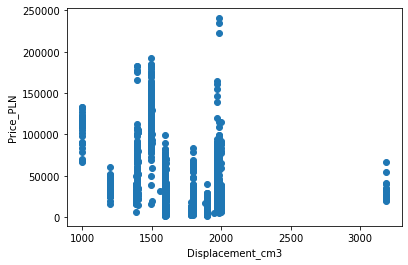

In [52]:
price_plot(audi_a3_cars,"Displacement_cm3")

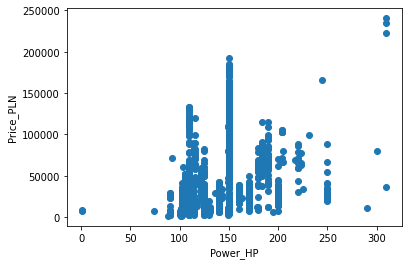

In [53]:
price_plot(audi_a3_cars,"Power_HP")

In [54]:
correlations = audi_a3_cars.iloc[:, 1:].corrwith(audi_a3_cars['Price'])
print(correlations)

Production_year     0.853472
Mileage_km         -0.764658
Power_HP            0.354174
Displacement_cm3   -0.301169
dtype: float64


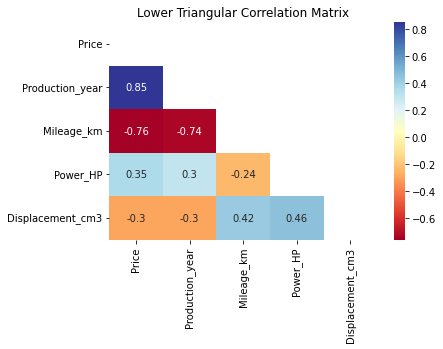

In [55]:
correlation_matrix = audi_a3_cars.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, mask=mask, annot=True, cmap='RdYlBu')
plt.title('Lower Triangular Correlation Matrix')
plt.show()

Due to small effect of engine power and displacement on the price of a vehicle, it was decided that only cars with a displacement of 2000ccm would be analysed to simplify analizis.

In [56]:
audi_a3_2010 = audi_a3_cars[audi_a3_cars["Production_year"] == 2010]
audi_a3_2000ccm = audi_a3_cars[audi_a3_cars["Displacement_cm3"] >= 1950]
audi_a3_2000ccm = audi_a3_2000ccm[audi_a3_2000ccm["Displacement_cm3"] <= 2050]
audi_a3_2000ccm = audi_a3_2000ccm.dropna()

In [57]:
if "audi_cars_data.csv" not in os.listdir("data"):
    audi_a3_2000ccm.to_csv('data/audi_cars_data.csv', index=False)

### Summary

In [58]:
audi_a3_2000ccm.head()

,Price,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3
1929,49900.0,Audi,A3,2015,208000.0,150.0,1968.0
1932,13900.0,Audi,A3,2008,227000.0,140.0,1968.0
1933,21900.0,Audi,A3,2008,313855.0,140.0,1968.0
1934,19900.0,Audi,A3,2007,242000.0,170.0,1968.0
1936,22900.0,Audi,A3,2006,240000.0,200.0,1984.0


Polyfit equation:  
4988 x - 9.99e+06


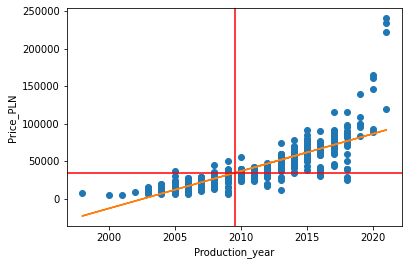

In [59]:
price_plot(audi_a3_2000ccm, "Production_year", True)

Polyfit equation:  
-0.2344 x + 8.109e+04


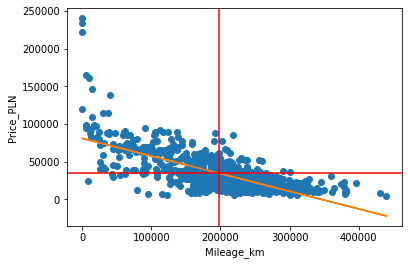

In [60]:
price_plot(audi_a3_2000ccm, "Mileage_km", True)

Polyfit equation:  
487.6 x - 4.072e+04


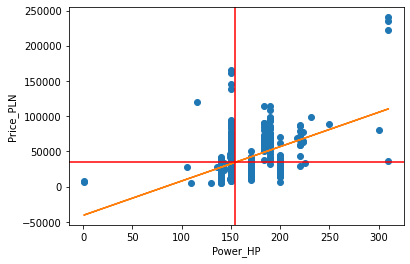

In [61]:
price_plot(audi_a3_2000ccm, "Power_HP", True)

Mean: 198361.37403598972


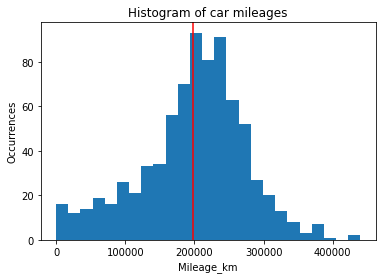

In [62]:
mileage_mean = np.mean(audi_a3_2000ccm["Mileage_km"])
print(f"Mean: {mileage_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Mileage_km"], bins = 25)
plt.axvline(mileage_mean, color="red")
plt.xlabel("Mileage_km")
plt.ylabel("Occurrences")
plt.title("Histogram of car mileages")
plt.show()

Mean: 2009.5719794344473


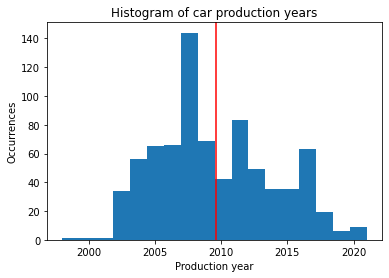

In [63]:
prod_mean = np.mean(audi_a3_2000ccm["Production_year"])
print(f"Mean: {prod_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Production_year"], bins = 18)
plt.axvline(prod_mean, color="red")
plt.xlabel("Production year")
plt.ylabel("Occurrences")
plt.title("Histogram of car production years")
plt.show()

Mean: 34600.235218509


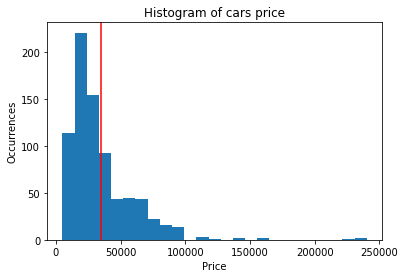

In [64]:
price_mean = np.mean(audi_a3_2000ccm["Price"])
print(f"Mean: {price_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm["Price"], bins = 25)
plt.axvline(price_mean, color="red")
plt.xlabel("Price")
plt.ylabel("Occurrences")
plt.title("Histogram of cars price")
plt.show()

## Data standarization ##

Due to the diversity of the data (production year (values form 2003 to 2021), mileage (values from 0 to 400000), price (values from 0 to 160000)), we decided to standardise the data using the MinMax scalar. This way we got all the data in the range from 0 to 1, without loosing information about data and making it easier to analyze it.

In [65]:
scaler = MinMaxScaler()
audi_a3_2000ccm_standarized_data = scaler.fit_transform(audi_a3_2000ccm.loc[:,["Price", "Production_year", "Mileage_km"]])
audi_a3_2000ccm_standarized = pd.DataFrame(audi_a3_2000ccm_standarized_data,columns=["Price", "Production_year", "Mileage_km"])
audi_a3_2000ccm_standarized.describe()

,Price,Production_year,Mileage_km
count,778.000000,778.000000,778.000000
mean,0.125764,0.503130,0.450820
std,0.110705,0.190895,0.173469
min,0.000000,0.000000,0.000000
25%,0.053109,0.347826,0.363635
50%,0.093048,0.478261,0.470453
75%,0.160497,0.652174,0.561363
max,1.000000,1.000000,1.000000


Polyfit equation:  
0.4875 x - 0.1195


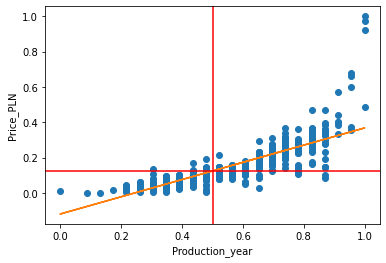

Polyfit equation:  
-0.4382 x + 0.3233


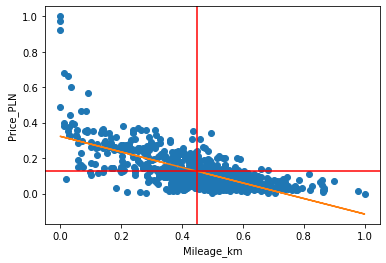

In [66]:
price_plot(audi_a3_2000ccm_standarized,"Production_year",True)
price_plot(audi_a3_2000ccm_standarized,"Mileage_km",True)

Mean: 0.45082005649101414


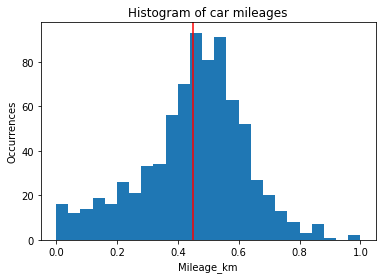

Mean: 0.5031295406281482


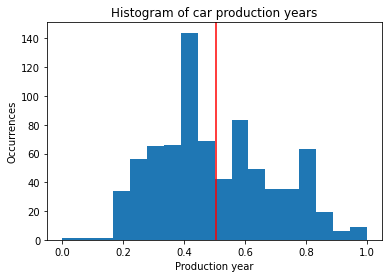

Mean: 0.12576418221431998
Var: 0.012239734156792626


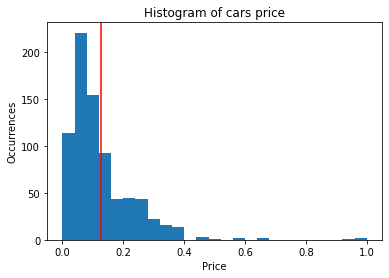

In [67]:
mileage_mean = np.mean(audi_a3_2000ccm_standarized["Mileage_km"])
print(f"Mean: {mileage_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm_standarized["Mileage_km"], bins = 25)
plt.axvline(mileage_mean, color="red")
plt.xlabel("Mileage_km")
plt.ylabel("Occurrences")
plt.title("Histogram of car mileages")
plt.show()

prod_mean = np.mean(audi_a3_2000ccm_standarized["Production_year"])
print(f"Mean: {prod_mean}")
plt.figure()
plt.hist(audi_a3_2000ccm_standarized["Production_year"], bins = 18)
plt.axvline(prod_mean, color="red")
plt.xlabel("Production year")
plt.ylabel("Occurrences")
plt.title("Histogram of car production years")
plt.show()

price_mean = np.mean(audi_a3_2000ccm_standarized["Price"])
price_var = np.var(audi_a3_2000ccm_standarized["Price"])
print(f"Mean: {price_mean}")
print(f"Var: {price_var}")
plt.figure()
plt.hist(audi_a3_2000ccm_standarized["Price"], bins = 25)
plt.axvline(price_mean, color="red")
plt.xlabel("Price")
plt.ylabel("Occurrences")
plt.title("Histogram of cars price")
plt.show()

In [68]:
if 'audi_data_standarized.csv' not in os.listdir("data"):
    audi_a3_2000ccm_standarized.to_csv('data/audi_data_standarized.csv', index=False)

In [69]:
audi_a3_2000ccm_standarized = pd.read_csv("data/audi_data_standarized.csv")
audi_a3_2000ccm_standarized.head()

,Price,Production_year,Mileage_km
0,0.190769,0.739130,0.472726
1,0.037814,0.434783,0.515908
2,0.071804,0.434783,0.713306
3,0.063306,0.391304,0.549999
4,0.076053,0.347826,0.545454


# 3. Model

For this project we specified two prior models of exponential range distribution. We wanted to check how adding highly corelated parameter to the model will affect price estimation. 
In the first model we used linear regression model with exponnenital distribution. We estimate price only based on the production year. In the second model we add mileage as well.

## 3.1 Model 1- prior

In [70]:
model_exp1_ppc = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model1_ppc.stan')

In [71]:
N = len(audi_a3_2000ccm_standarized)

data = {"N": N, 
        "mileage" : np.linspace(0.01,1,N),
        "production_year" : np.linspace(0.01,1,N)
}
sim_exp_fit1=model_exp1_ppc.sample(data=data)
sim_exp_fit1_pd = sim_exp_fit1.draws_pd()
sim_exp_fit1_pd.head()

16:05:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▍         | 00:00 Status



chain 1 |█▊        | 00:00 Iteration: 200 / 1000 [ 20%]  (Sampling)


chain 1 |██▋       | 00:00 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████▌     | 00:00 Iteration: 800 / 1000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

16:05:36 - cmdstanpy - INFO - CmdStan done processing.


,lp__,accept_stat__,price[1],price[2],price[3],price[4],price[5],price[6],price[7],price[8],...,price[773],price[774],price[775],price[776],price[777],price[778],alpha,beta,sigma,lambda
0,0.0,0.0,0.189050,0.067975,0.016232,0.284309,0.514610,0.071915,0.189115,0.118947,...,0.053245,0.067783,0.028893,0.027732,0.011870,0.024682,0.143371,0.356313,0.141801,39.9896
1,0.0,0.0,0.112777,0.041280,0.089557,0.070160,0.035180,0.208445,0.243089,0.190097,...,0.066825,0.007717,0.088896,0.019470,0.011874,0.022282,0.186083,0.340722,0.182071,39.9385
2,0.0,0.0,0.106373,0.078541,0.099282,0.011526,0.147559,0.026725,0.167083,0.025590,...,0.011830,0.015457,0.041428,0.040007,0.003612,0.023863,0.208361,0.355158,0.134164,40.0133
3,0.0,0.0,0.070648,0.057806,0.238537,0.252547,0.449770,0.039843,0.028248,0.151474,...,0.008071,0.115362,0.062247,0.032111,0.035458,0.009186,0.150661,0.364589,0.162502,40.1533
4,0.0,0.0,0.123136,0.435175,0.444392,0.225076,0.561102,0.061190,0.114695,0.168846,...,0.022551,0.022506,0.075144,0.008225,0.145246,0.017665,0.152933,0.359761,0.161398,39.8129


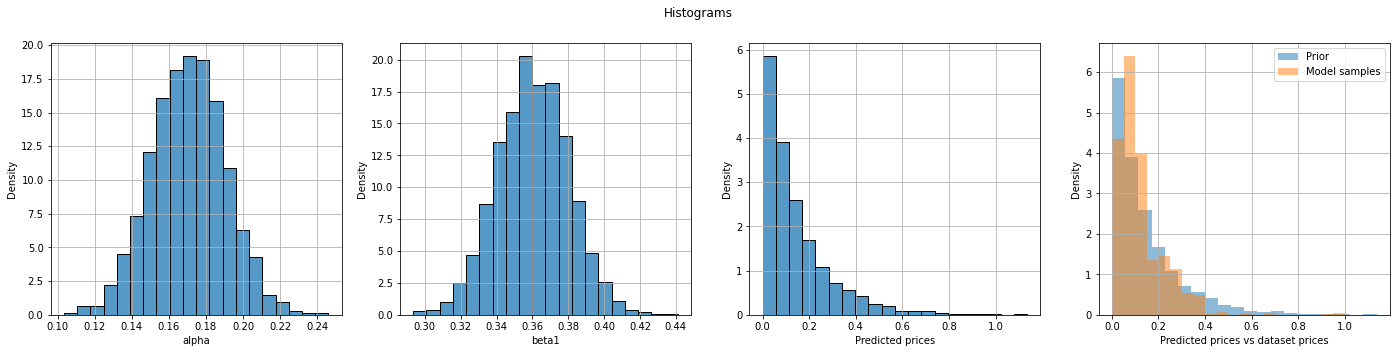

In [72]:
_, ax = plt.subplots(1, 4, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_fit1_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_fit1_pd, x="beta", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_fit1_pd, x="price[1]", stat="density", ax=ax[2], bins=BINS)

ax[3].hist(sim_exp_fit1_pd["price[1]"], bins=BINS, alpha=0.5, density=True, label="Prior")
ax[3].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("Predicted prices"), 
ax[3].set_xlabel("Predicted prices vs dataset prices")

ax[3].set_ylabel("Density")
ax[3].legend()
plt.suptitle("Histograms")
plt.show()

## 3.2 Model 1- posterior

In [73]:
model_exp_fit = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model1_fit.stan')
N = len(audi_a3_2000ccm_standarized)
#Parameters

data = {"N": N, 
        "mileage" : audi_a3_2000ccm_standarized['Mileage_km'],
        "production_year" : audi_a3_2000ccm_standarized['Production_year'],
        "price_observed": audi_a3_2000ccm_standarized['Price']
        }

sim_exp_pos1_fit=model_exp_fit.sample(data=data)
sim_exp_pos1_fit_pd = sim_exp_pos1_fit.draws_pd()
sim_exp_pos1_fit_pd.head()

16:05:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:03 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)


16:05:42 - cmdstanpy - INFO - CmdStan done processing.
16:05:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: exponential_lpdf: Inverse scale parameter is -inf, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model1_fit.stan', line 28, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -inf, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model1_fit.stan', line 28, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -2.02448e+204, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model1_fit.stan', line 28, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -6.34165e+52, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model1_fit.stan', line 28, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -2.3167e+14, but must be positive

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_lik[769],log_lik[770],log_lik[771],log_lik[772],log_lik[773],log_lik[774],log_lik[775],log_lik[776],log_lik[777],log_lik[778]
0,692.098,0.572934,0.539885,3.0,7.0,0.0,-688.283,0.153435,0.110960,0.169984,...,1.12846,1.49796,1.13214,1.68011,0.880573,1.26412,0.099497,1.39851,1.46161,0.874472
1,691.088,0.977385,0.539885,2.0,3.0,0.0,-690.624,0.152478,0.107383,0.181998,...,1.12874,1.49394,1.13238,1.67440,0.883235,1.26457,0.113800,1.39539,1.45938,0.877554
2,692.558,1.000000,0.539885,2.0,3.0,0.0,-690.096,0.148523,0.097343,0.141857,...,1.12849,1.47375,1.13195,1.64683,0.893424,1.26447,0.170088,1.37984,1.44874,0.889279
3,692.318,0.985012,0.539885,3.0,7.0,0.0,-691.310,0.142897,0.116667,0.164329,...,1.12885,1.47267,1.13238,1.64816,0.890742,1.26487,0.138587,1.38061,1.45639,0.885425
4,690.655,0.866542,0.539885,2.0,7.0,0.0,-689.096,0.167925,0.078306,0.135565,...,1.12883,1.50632,1.13245,1.68683,0.883023,1.26479,0.143090,1.40212,1.45172,0.878917


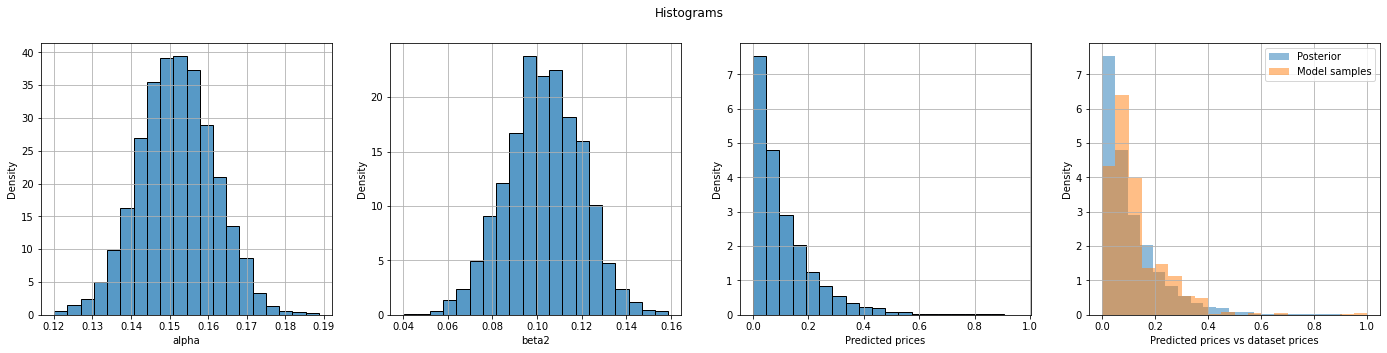

In [74]:
_, ax = plt.subplots(1, 4, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_pos1_fit_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_pos1_fit_pd, x="beta", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_pos1_fit_pd, x="price_estimated[1]", stat="density", ax=ax[2], bins=BINS)

ax[3].hist(sim_exp_pos1_fit_pd["price_estimated[1]"], bins=BINS, alpha=0.5, density=True, label="Posterior")
ax[3].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta2"), 
ax[2].set_xlabel("Predicted prices"), 
ax[3].set_xlabel("Predicted prices vs dataset prices")

ax[3].set_ylabel("Density")
ax[3].legend()
plt.suptitle("Histograms")
plt.show()

## 3.3 Model 2- prior

In [75]:
model_exp2_ppc = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model2_ppc.stan')

#Parameters
N = len(audi_a3_2000ccm_standarized)
mu_a =0.17
sig_a =0.02
mu_b1 = 0.36
sig_b1 = 0.02
mu_b2 = 0.36
sig_b2 = 0.02

data = {"N": N, 
        "mileage" : np.linspace(0.01,1,N),
        "production_year" : np.linspace(0.01,1,N),
        "mu_a" : mu_a,
        "sig_a" : sig_a,
        "mu_b1" : mu_b1,
        "mu_b2" : mu_b2,
        "sig_b1" : sig_b1,
        "sig_b2" : sig_b2,
        }


sim_exp_fit2=model_exp2_ppc.sample(data=data)
sim_exp_fit2_pd = sim_exp_fit2.draws_pd()
sim_exp_fit2_pd.head()

16:05:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)


chain 1 |██▎       | 00:00 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

16:05:49 - cmdstanpy - INFO - CmdStan done processing.


,lp__,accept_stat__,price[1],price[2],price[3],price[4],price[5],price[6],price[7],price[8],...,price[774],price[775],price[776],price[777],price[778],alpha,beta1,beta2,sigma,lambda
0,0.0,0.0,0.184199,0.134068,0.327619,0.096741,0.063453,0.065488,0.196573,0.038940,...,0.046434,0.012622,0.193591,0.173505,0.137048,0.170683,0.379997,0.381718,0.150392,40.1163
1,0.0,0.0,0.211163,0.044423,0.065961,0.147086,0.025903,0.238402,0.012077,0.410823,...,0.089005,0.213886,0.027606,0.018269,0.228202,0.161693,0.348940,0.377396,0.139884,39.7603
2,0.0,0.0,0.298958,0.288630,0.144839,0.109072,0.060064,0.022908,0.486441,0.390172,...,0.017219,0.026318,0.105931,0.051712,0.705793,0.178272,0.352742,0.378643,0.150802,39.9746
3,0.0,0.0,0.009465,0.091675,0.307397,0.016449,0.042654,0.289606,0.022167,0.464182,...,0.006724,0.074819,0.012657,0.007828,0.148187,0.181938,0.347776,0.352984,0.183120,39.8990
4,0.0,0.0,0.032726,0.043979,0.200785,0.236112,0.055488,0.138474,0.155195,0.121279,...,0.161437,0.072040,0.399204,0.021664,0.296342,0.162156,0.387747,0.379759,0.144716,40.1088


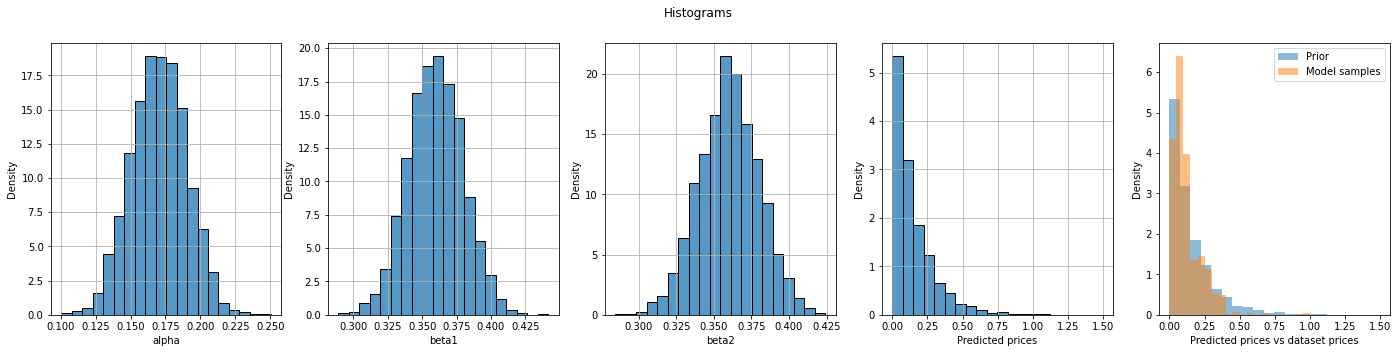

In [76]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_fit2_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_fit2_pd, x="beta1", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_fit2_pd, x="beta2", stat="density", ax=ax[2], bins=BINS)
sns.histplot(data=sim_exp_fit2_pd, x="price[1]", stat="density", ax=ax[3], bins=BINS)

ax[4].hist(sim_exp_fit2_pd["price[1]"], bins=BINS, alpha=0.5, density=True, label="Prior")
ax[4].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("beta2"), 
ax[3].set_xlabel("Predicted prices"), 
ax[4].set_xlabel("Predicted prices vs dataset prices")

ax[4].set_ylabel("Density")
ax[4].legend()
plt.suptitle("Histograms")
plt.show()

## 3.4 Model 2- posterior

In [77]:
model_exp2_fit = cmdstanpy.CmdStanModel(stan_file='stan_files/exp_model2_fit.stan')
N = len(audi_a3_2000ccm_standarized)
#Parameters

data = {"N": N, 
        "mileage" : audi_a3_2000ccm_standarized['Mileage_km'],
        "production_year" : audi_a3_2000ccm_standarized['Production_year'],
        "price_observed": audi_a3_2000ccm_standarized['Price']
        }

sim_exp_pos2_fit=model_exp2_fit.sample(data=data)
sim_exp_pos2_fit_pd = sim_exp_pos2_fit.draws_pd()
sim_exp_pos2_fit_pd.head()

16:05:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:03 Iteration: 1500 / 2000 [ 75%]  (Sampling)


cha


16:05:58 - cmdstanpy - INFO - CmdStan done processing.
16:05:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: exponential_lpdf: Inverse scale parameter is -5.69584e+200, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model2_fit.stan', line 31, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -1.17329e+201, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model2_fit.stan', line 31, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -1.37464e+51, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model2_fit.stan', line 31, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -1.04248e+13, but must be positive finite! (in '/home/car_prices_pr/DA/project/stan_files/exp_model2_fit.stan', line 31, column 4 to column 52)
	Exception: exponential_lpdf: Inverse scale parameter is -1139.64, but mu

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta1,beta2,...,log_lik[769],log_lik[770],log_lik[771],log_lik[772],log_lik[773],log_lik[774],log_lik[775],log_lik[776],log_lik[777],log_lik[778]
0,560.390,0.837326,0.437882,2.0,7.0,0.0,-558.364,0.205592,0.140972,0.104569,...,1.12870,1.48427,1.12778,1.57887,0.883291,1.25273,0.155661,1.30278,1.47530,0.876174
1,559.187,0.999653,0.437882,3.0,7.0,0.0,-557.994,0.218823,0.149800,0.123871,...,1.12187,1.52321,1.13250,1.63926,0.854922,1.23016,0.037639,1.34508,1.47203,0.843799
2,560.906,1.000000,0.437882,3.0,15.0,0.0,-558.348,0.202366,0.133899,0.117019,...,1.12750,1.49518,1.13088,1.60230,0.875397,1.24680,0.110464,1.32207,1.47538,0.866772
3,560.834,0.887395,0.437882,3.0,7.0,0.0,-558.796,0.197105,0.110171,0.110364,...,1.12752,1.50026,1.13177,1.62314,0.875022,1.25180,0.109269,1.34253,1.47524,0.867060
4,561.584,0.850461,0.437882,3.0,7.0,0.0,-558.167,0.201052,0.127939,0.109552,...,1.12837,1.48940,1.12984,1.59599,0.880354,1.25217,0.135663,1.31907,1.47529,0.872798


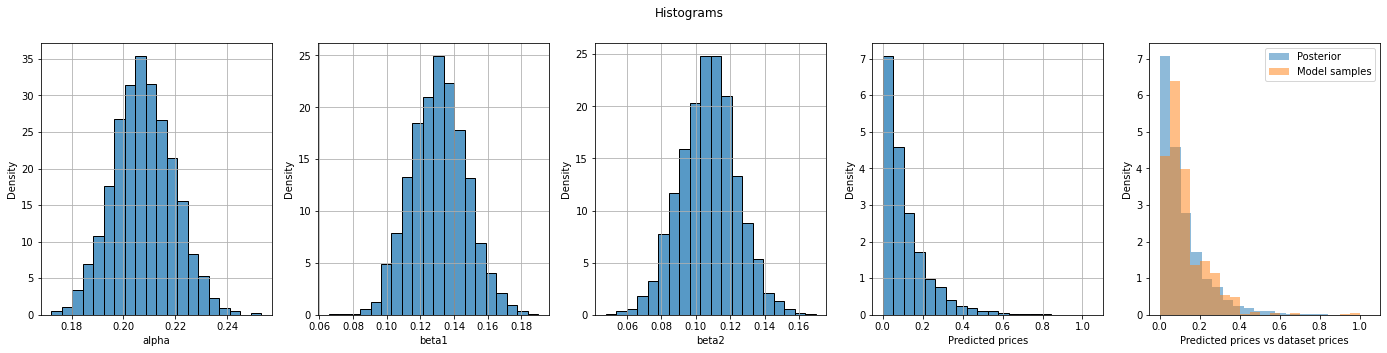

In [78]:
_, ax = plt.subplots(1, 5, figsize=(24, 5))
ax = ax.flatten()
sns.histplot(data=sim_exp_pos2_fit_pd, x="alpha", stat="density", ax=ax[0], bins=BINS)
sns.histplot(data=sim_exp_pos2_fit_pd, x="beta1", stat="density", ax=ax[1], bins=BINS)
sns.histplot(data=sim_exp_pos2_fit_pd, x="beta2", stat="density", ax=ax[2], bins=BINS)
sns.histplot(data=sim_exp_pos2_fit_pd, x="price_estimated[1]", stat="density", ax=ax[3], bins=BINS)

ax[4].hist(sim_exp_pos2_fit_pd["price_estimated[1]"], bins=BINS, alpha=0.5, density=True, label="Posterior")
ax[4].hist(audi_a3_2000ccm_standarized["Price"], bins=BINS, alpha=0.5, density=True, label="Model samples")


ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

ax[0].set_xlabel("alpha"), 
ax[1].set_xlabel("beta1"), 
ax[2].set_xlabel("beta2"), 
ax[3].set_xlabel("Predicted prices"), 
ax[4].set_xlabel("Predicted prices vs dataset prices")

ax[4].set_ylabel("Density")
ax[4].legend()
plt.suptitle("Histograms")
plt.show()

In [79]:
summary = sim_exp_pos2_fit.summary()
summary.head(6)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,559.653000,0.035873,1.594030,556.579000,559.972000,561.600000,1974.53,182.996,0.999913
alpha,0.207764,0.000240,0.011628,0.188496,0.207444,0.227022,2353.33,218.103,1.001290
beta1,0.130950,0.000323,0.016536,0.104115,0.130913,0.158260,2622.57,243.056,1.000410
beta2,0.107141,0.000289,0.016439,0.079880,0.107427,0.134030,3224.85,298.874,1.000410
sigma,0.149928,0.000346,0.020343,0.116757,0.150055,0.182622,3460.46,320.710,0.999825
lambda,39.874200,0.002913,0.200409,39.544700,39.874000,40.208100,4734.43,438.780,0.999322


# 4. Model comparison

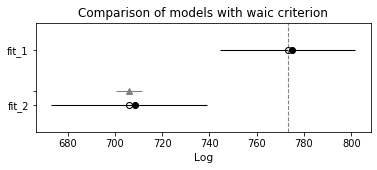

In [85]:
compare_model_waic = az.compare(
 {
 "fit_1": az.from_cmdstanpy(sim_exp_pos1_fit),
 "fit_2": az.from_cmdstanpy(sim_exp_pos2_fit)
 },
 ic="waic",
)

ax = az.plot_compare(compare_model_waic)
ax.set_title(f"Comparison of models with waic criterion")
plt.show()


In [86]:
display(compare_model_waic)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fit_1,0,773.187452,1.680854,0.00000,1.0,28.564776,0.000000,False,log
fit_2,1,705.928822,2.579213,67.25863,0.0,32.961107,5.462958,False,log


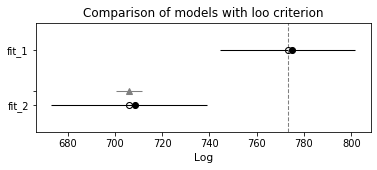

In [87]:
compare_model_loo = az.compare(
 {
 "fit_1": az.from_cmdstanpy(sim_exp_pos1_fit),
 "fit_2": az.from_cmdstanpy(sim_exp_pos2_fit)
 },
 ic="loo",
)

ax = az.plot_compare(compare_model_loo)
ax.set_title(f"Comparison of models with loo criterion")
plt.show()

In [88]:
display(compare_model_loo)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
fit_1,0,773.186874,1.681432,0.000000,1.0,28.564931,0.000000,False,log
fit_2,1,705.931121,2.576914,67.255753,0.0,32.960433,5.461987,False,log
